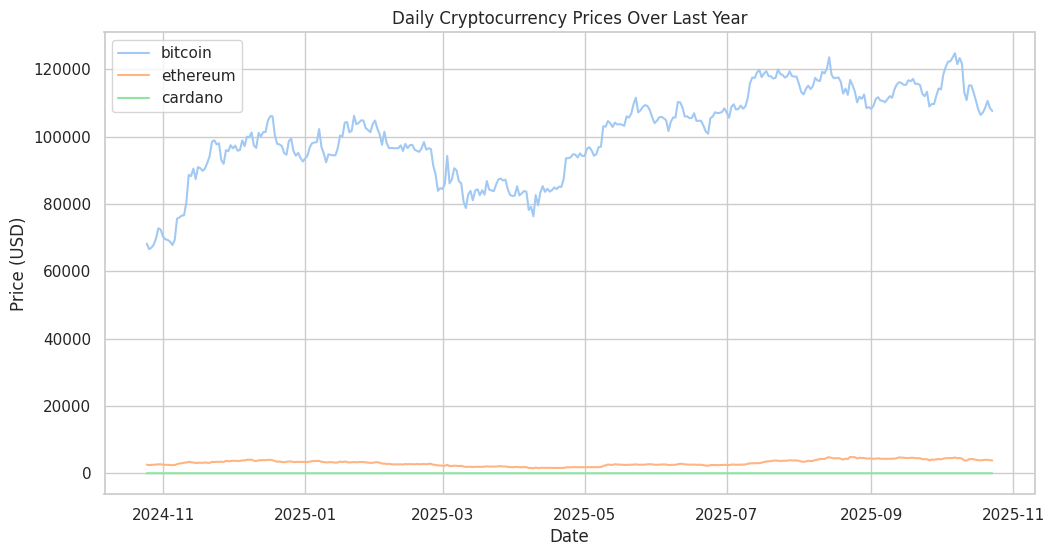

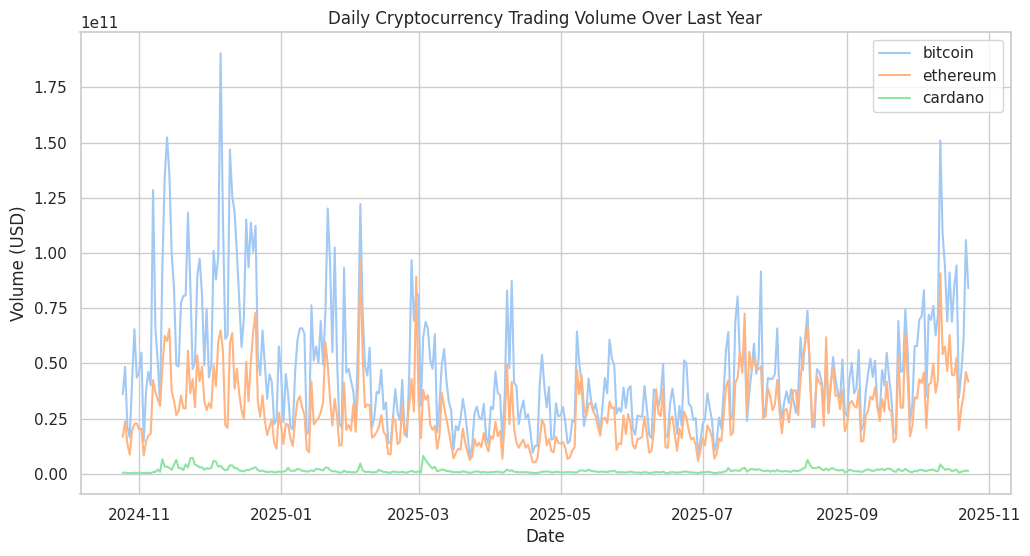

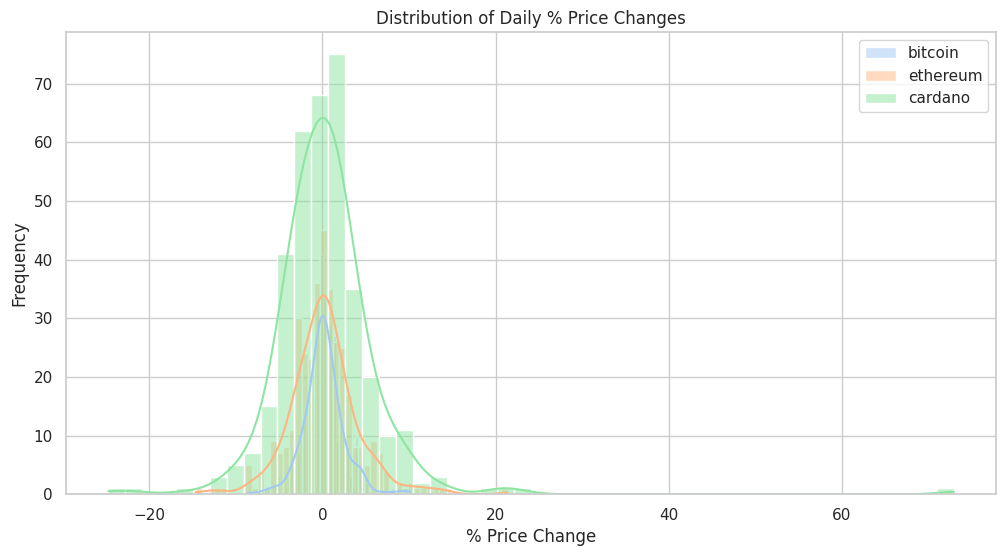

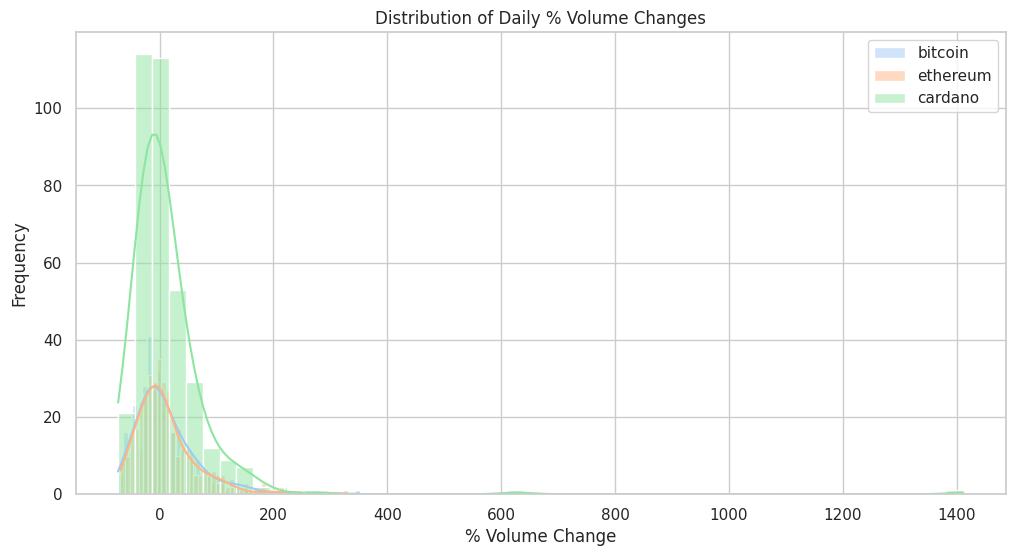

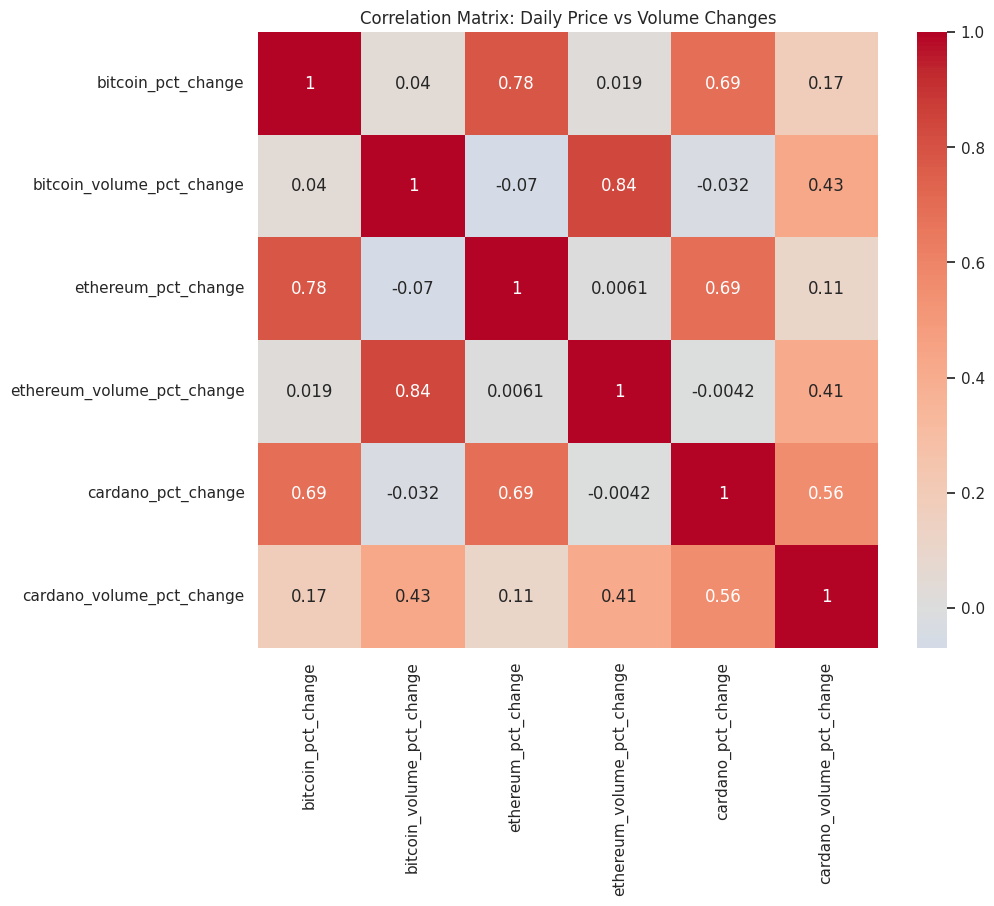

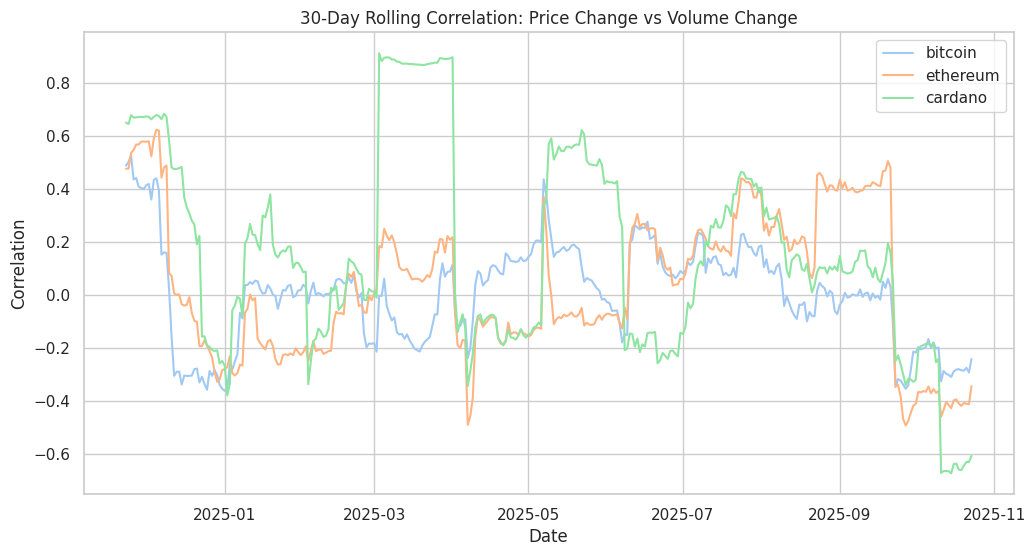


--- BITCOIN Regression (Price % Change vs Volume % Change) ---
Intercept: 0.1387
Coefficient: 0.0016


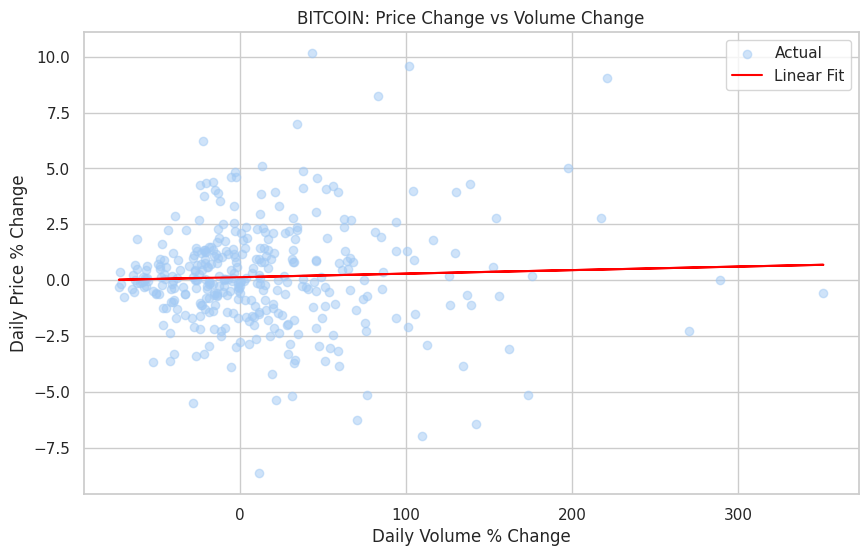


--- ETHEREUM Regression (Price % Change vs Volume % Change) ---
Intercept: 0.1872
Coefficient: 0.0004


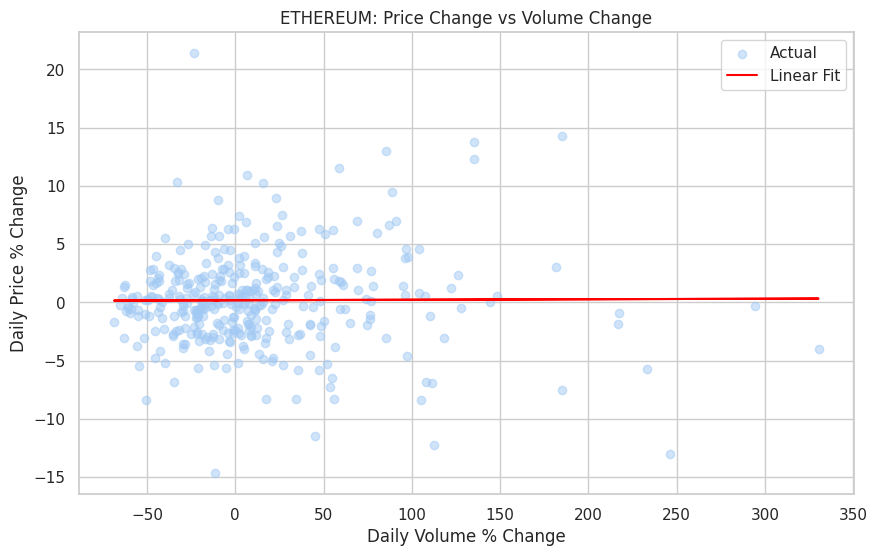


--- CARDANO Regression (Price % Change vs Volume % Change) ---
Intercept: -0.1683
Coefficient: 0.0375


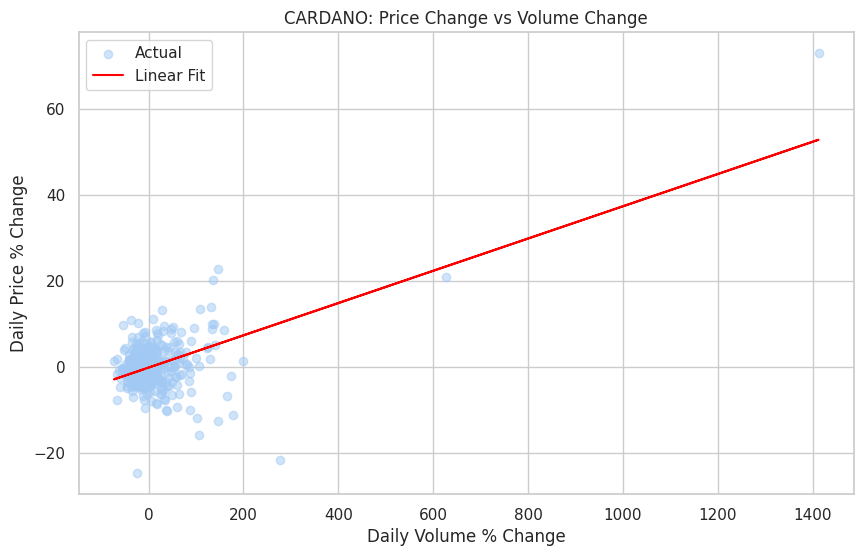

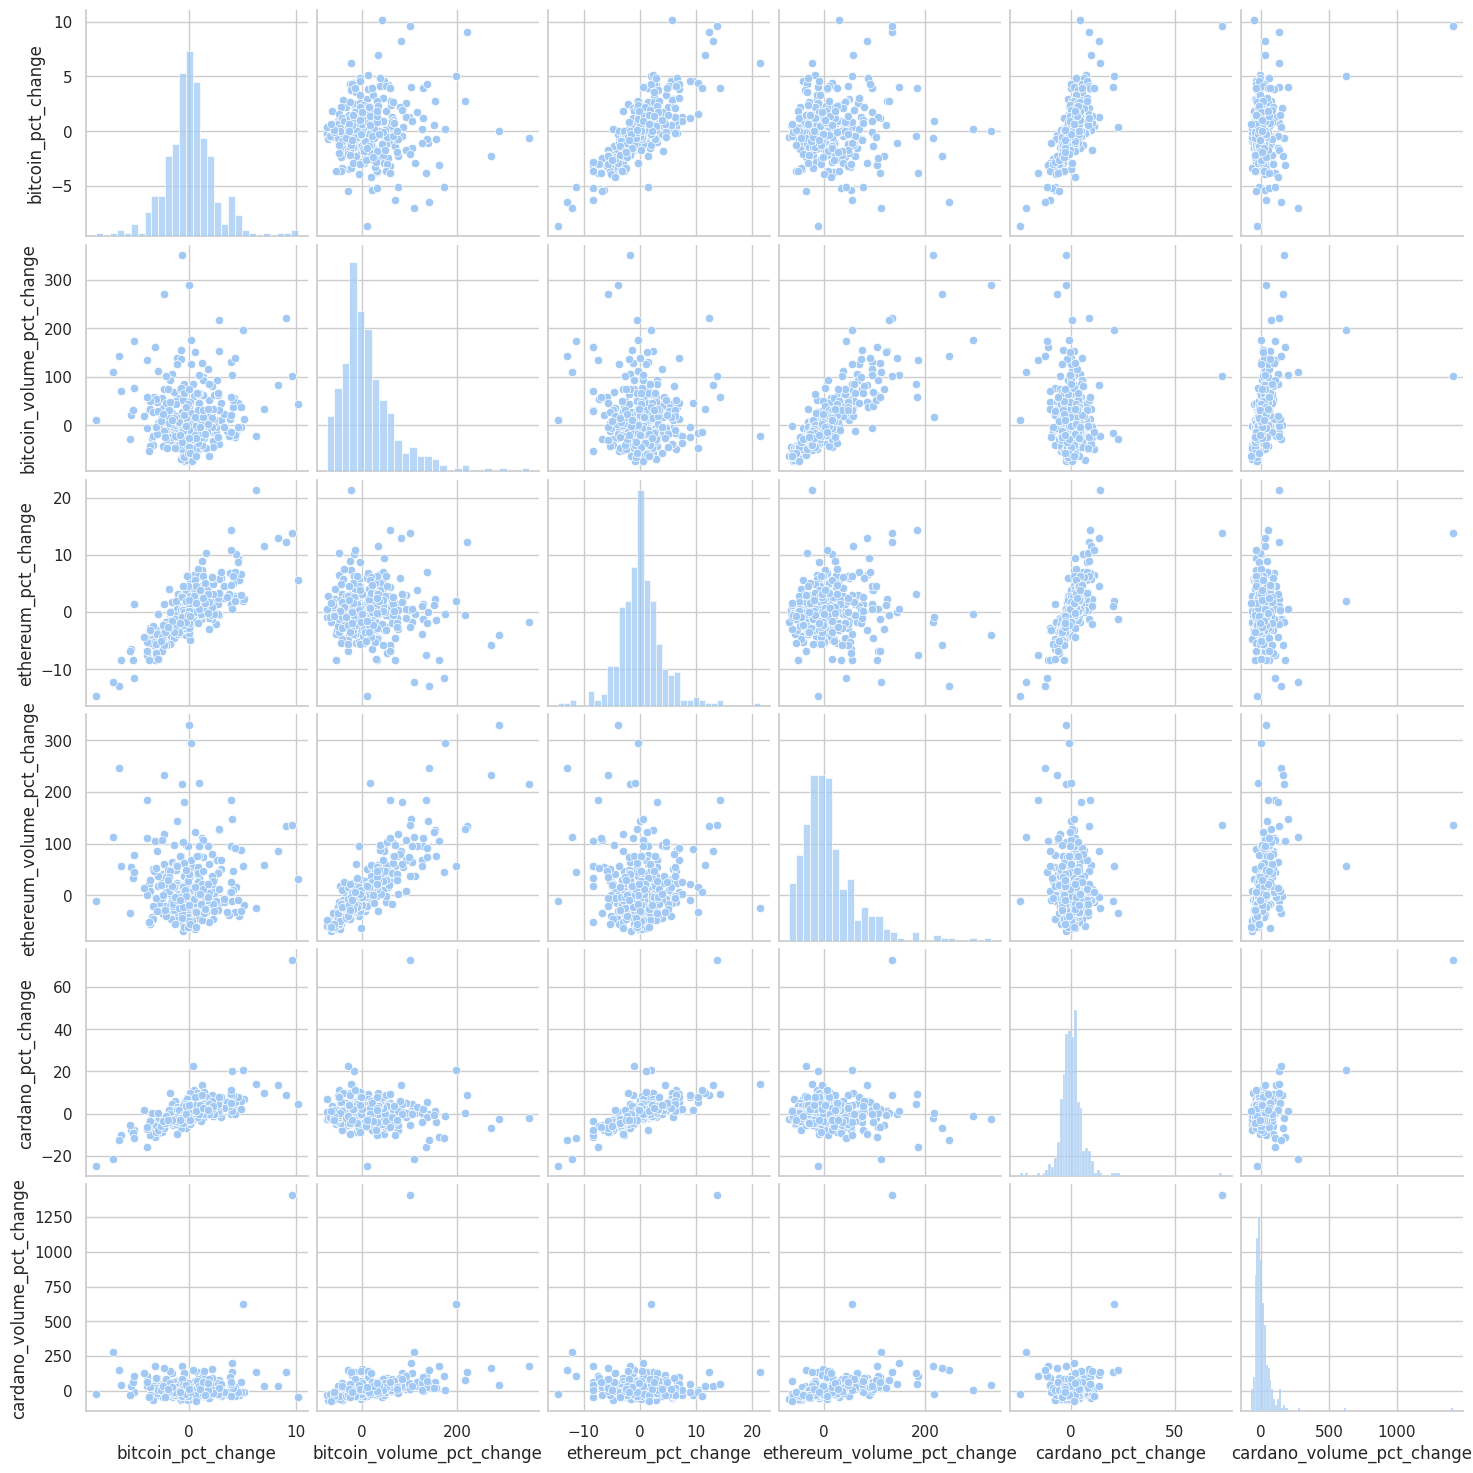

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

sns.set_theme(style="whitegrid", palette="pastel")

# getting all the crypto data
coins = ["bitcoin", "ethereum", "cardano"]
vs_currency = "usd"
days = "365"

crypto_data = pd.DataFrame()

for coin in coins:
    url = f"https://api.coingecko.com/api/v3/coins/{coin}/market_chart"
    params = {"vs_currency": vs_currency, "days": days, "interval": "daily"}

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(f"Failed to fetch {coin} data: {response.status_code}")
        continue

    data = response.json()

    df_coin = pd.DataFrame(data["prices"], columns=["timestamp", f"{coin}_price"])
    df_coin[f"{coin}_volume"] = [v[1] for v in data["total_volumes"]]
    df_coin["date"] = pd.to_datetime(df_coin["timestamp"], unit='ms')
    df_coin = df_coin[["date", f"{coin}_price", f"{coin}_volume"]]

    if crypto_data.empty:
        crypto_data = df_coin
    else:
        crypto_data = pd.merge(crypto_data, df_coin, on="date")


for coin in coins:
    crypto_data[f"{coin}_pct_change"] = crypto_data[f"{coin}_price"].pct_change() * 100
    crypto_data[f"{coin}_volume_pct_change"] = crypto_data[f"{coin}_volume"].pct_change() * 100

crypto_data.dropna(inplace=True)

# Price trends for all the crypto currencies
plt.figure(figsize=(12,6))
for coin in coins:
    sns.lineplot(x=crypto_data["date"], y=crypto_data[f"{coin}_price"], label=coin)
plt.title("Daily Cryptocurrency Prices Over Last Year")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

# Trading volume trends for all 3
plt.figure(figsize=(12,6))
for coin in coins:
    sns.lineplot(x=crypto_data["date"], y=crypto_data[f"{coin}_volume"], label=coin)
plt.title("Daily Cryptocurrency Trading Volume Over Last Year")
plt.xlabel("Date")
plt.ylabel("Volume (USD)")
plt.show()

# Distribution of daily % price changes
plt.figure(figsize=(12,6))
for coin in coins:
    sns.histplot(crypto_data[f"{coin}_pct_change"], bins=50, kde=True, label=coin, alpha=0.5)
plt.title("Distribution of Daily % Price Changes")
plt.xlabel("% Price Change")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Distribution of daily % volume changes
plt.figure(figsize=(12,6))
for coin in coins:
    sns.histplot(crypto_data[f"{coin}_volume_pct_change"], bins=50, kde=True, label=coin, alpha=0.5)
plt.title("Distribution of Daily % Volume Changes")
plt.xlabel("% Volume Change")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# linear correlation analysis of changes
corr_cols = []
for coin in coins:
    corr_cols.extend([f"{coin}_pct_change", f"{coin}_volume_pct_change"])

corr_matrix = crypto_data[corr_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix: Daily Price vs Volume Changes")
plt.show()

# 30 day rolling corellation
window = 30
plt.figure(figsize=(12,6))
for coin in coins:
    rolling_corr = crypto_data[f"{coin}_pct_change"].rolling(window).corr(
        crypto_data[f"{coin}_volume_pct_change"]
    )
    sns.lineplot(x=crypto_data["date"], y=rolling_corr, label=coin)

plt.title(f"{window}-Day Rolling Correlation: Price Change vs Volume Change")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.show()

# regression analysis and changes (fix this)
for coin in coins:
    X = crypto_data[[f"{coin}_volume_pct_change"]].values
    y = crypto_data[f"{coin}_pct_change"].values

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    print(f"\n--- {coin.upper()} Regression (Price % Change vs Volume % Change) ---")
    print(f"Intercept: {model.intercept_:.4f}")
    print(f"Coefficient: {model.coef_[0]:.4f}")

    plt.figure(figsize=(10,6))
    plt.scatter(X, y, alpha=0.5, label="Actual")
    plt.plot(X, y_pred, color='red', label="Linear Fit")
    plt.title(f"{coin.upper()}: Price Change vs Volume Change")
    plt.xlabel("Daily Volume % Change")
    plt.ylabel("Daily Price % Change")
    plt.legend()
    plt.show()

# pairplot (remove this maybe)
sns.pairplot(crypto_data[corr_cols])
plt.show()
